<a href="https://colab.research.google.com/github/jacobdwatters/NIOSH-Project/blob/main/KerasNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Setups

In [2]:
import numpy as np
from numpy.random import seed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import scipy as sp
from scipy import stats

import joblib

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load and Process Data

In [5]:
path_after_2010 = '/content/gdrive/My Drive/NIOSH Project/data/violations_processed_after_2010.csv'
violation_data = pd.read_csv(path_after_2010)

In [6]:
FEATURES = ['MINE_TYPE', 'COAL_METAL_IND', 'SIG_SUB', 'LIKELIHOOD', 
            'INJ_ILLNESS', 'NO_AFFECTED', 'NEGLIGENCE', 'VIOLATOR_VIOLATION_CNT',
            'VIOLATOR_INSPECTION_DAY_CNT']
TARGETS = ['PROPOSED_PENALTY']

X = violation_data[FEATURES]
y = violation_data[TARGETS]

In [7]:
# Define which columns should be encoded vs scaled
columns_to_encode = ['MINE_TYPE', 'COAL_METAL_IND', 'LIKELIHOOD', 'INJ_ILLNESS', 'SIG_SUB', 'NEGLIGENCE']
columns_to_scale  = ['VIOLATOR_VIOLATION_CNT', 'NO_AFFECTED', 'VIOLATOR_INSPECTION_DAY_CNT']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(X[columns_to_scale])
encoded_columns = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre = np.concatenate([scaled_columns, encoded_columns], axis=1)
np.nan_to_num(X_pre, copy=False)

print('Features shape:', X_pre.shape)

Features shape: (1429135, 24)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size = 0.25, random_state = 0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_train shape:', y_test.shape)

X_train shape: (1071851, 24)
X_test shape: (357284, 24)
y_train shape: (1071851, 1)
y_train shape: (357284, 1)


## Neural Network Model

In [59]:
def scheduler(epoch, lr):
  if epoch < 85:
    return lr
  else: # Drop learning rate after the first 85 epochs
    return lr*np.exp(-0.05)

In [69]:
batch_size = 2**14
epochs = 120
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = keras.Sequential()

model.add(keras.Input(shape = (len(X_train[0]), ) ))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(1, activation="linear"))


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=opt)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    callbacks=[callback], validation_data=(X_test, y_test))

Epoch 1/120
66/66 [==============================] - 1s 8ms/step - loss: 11408516.0000 - val_loss: 9152761.0000 - lr: 0.0100
Epoch 2/120
66/66 [==============================] - 0s 5ms/step - loss: 8082129.0000 - val_loss: 6547791.0000 - lr: 0.0100
Epoch 3/120
66/66 [==============================] - 0s 5ms/step - loss: 6697624.5000 - val_loss: 6182168.0000 - lr: 0.0100
Epoch 4/120
66/66 [==============================] - 0s 5ms/step - loss: 6426393.0000 - val_loss: 6208868.5000 - lr: 0.0100
Epoch 5/120
66/66 [==============================] - 0s 5ms/step - loss: 6152067.0000 - val_loss: 5818208.5000 - lr: 0.0100
Epoch 6/120
66/66 [==============================] - 0s 5ms/step - loss: 5916386.0000 - val_loss: 5789541.5000 - lr: 0.0100
Epoch 7/120
66/66 [==============================] - 0s 5ms/step - loss: 5863867.0000 - val_loss: 5754465.0000 - lr: 0.0100
Epoch 8/120
66/66 [==============================] - 0s 5ms/step - loss: 5739401.0000 - val_loss: 5482417.0000 - lr: 0.0100
Epoch 9

In [70]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('r2 = %.3f' % r2)

11166/11166 [==============================] - 15s 1ms/step
r2 = 0.578


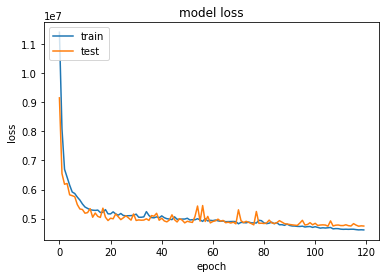

In [71]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save Model

In [72]:
model.save('/content/gdrive/My Drive/NIOSH Project/Nerual_Network_Model')